## Dividing cells

In [1]:
#import library
from libsbml import readSBML
from cobra import io,flux_analysis
from cobra.core import Reaction,Metabolite
from IPython import display
import time

##### Modelling

In [2]:
#import sbml file
dividing_model = io.sbml.create_cobra_model_from_sbml_file("PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
dividing_model.reactions.get_by_id("GLC_tx").upper_bound = 1000
dividing_model.reactions.get_by_id("GLC_tx").lower_bound = 0
dividing_model.reactions.get_by_id("Sucrose_tx").upper_bound = 0
dividing_model.reactions.get_by_id("Photon_tx").upper_bound = 0

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
dividing_model.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
dividing_model.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 0
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 0


#Create a Protein_b metabolites
rxn = dividing_model.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = dividing_model.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
formula_dict = rxn.check_mass_balance()
met.formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
met.charge = formula_dict["charge"]*-1
rxn.add_metabolites({met:1})


#### Data processed from Rontein et al 2002

In [3]:
import pandas as pd
data={"sSUCROSE_b":0.00023384868704189686,"sCIT_b":8.668117044773994e-05,"sMAL_b":2.9579139027799716e-05,"FRU":0.0003876698255039685,"GLC":0.0006427015896873639}
temp1 = data.keys()
temp2 = list()
for t in temp1:
    temp2.append(data.get(t))
df = pd.DataFrame(data={"mets":temp1,"amount":temp2})
df = df[['mets', 'amount']]
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [4]:

#Addd dividing biomass
rxn = Reaction("Biomass_dividing")
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Cellulose_b"):-1*0.004167174993906135})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*0.0002663702867671667})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Protein_b"):-1*0.0003168809295998026})
rxn.add_metabolites({dividing_model.metabolites.get_by_id("Starch_b"):-1*0.0011297601948076414})
dividing_model.add_reaction(rxn)

soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}

for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,METB:1})
        dividing_model.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,METB:1})
        dividing_model.add_reaction(rxn)
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,METB:1})
    dividing_model.add_reaction(rxn)
    
    rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
    rxn.add_metabolites({METB:-1*0.14*float(df["amount"][df["mets"]==met2])})
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
rxn.lower_bound = 0
rxn.upper_bound = 1000

dividing_model.reactions.get_by_id("Biomass_dividing").objective_coefficient=1
#dividing_model.reactions.get_by_id("GLC_tx").objective_coefficient=-1

solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Maximal glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x)


Maximal glucose uptake rate =
9.41386175027


In [5]:
### set max growth rate based on Rontein 2002 
#max growth rate = 2 mg/ml = 2 g/L
backup_dividing = dividing_model.copy()
rxn = dividing_model.reactions.get_by_id("Biomass_dividing")
formula_dict = rxn.check_mass_balance()
Biomass_MW2 = 0
for met in rxn.metabolites:
    Biomass_MW2=Biomass_MW2+(rxn.metabolites.get(met)*met.formula_weight*-1)
#max growth rate = 2 mg/ml = 2 g/L
rxn.upper_bound = 2.009/Biomass_MW2
rxn.lower_bound = 2.009/Biomass_MW2
solution = flux_analysis.parsimonious.pfba(dividing_model)
print("Glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x)


Glucose uptake rate =
0.0163391158878


cobra/core/metabolite.py:103 UserWarning: 17.2020450391 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 25.9492553613 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 5.7497158698 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 4.9536245179 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)
cobra/core/metabolite.py:103 UserWarning: 0.1420323181 is not an integer (in formula C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181)


In [6]:
2.009/Biomass_MW2

1.735644342487791

In [7]:
print("Glucose uptake rate =")
print(dividing_model.reactions.get_by_id("GLC_tx").x*dividing_model.metabolites.get_by_id("GLC_c").formula_weight)

Glucose uptake rate =
2.94358780119


##### Estiamtion of maintenance cell model

Maintenance was estimated by increasing ATPase flux until Carbon conversion efficiency (CCE) = 70%

In [8]:
from functions3 import generateATPbudget

Fraction = 0
i = 0
while Fraction < 0.3:
    i=i+0.001
    tempModel = dividing_model.copy()
    tempModel.reactions.get_by_id("ATPase_tx").lower_bound = i
    tempModel.reactions.get_by_id("ATPase_tx").upper_bound = i
    solution = flux_analysis.parsimonious.pfba(tempModel)
    Fraction = -1*solution.x_dict.get("CO2_tx")/(6*solution.x_dict.get("GLC_tx"))
    #print i
    #print Fraction
    #print solution.x_dict.get("CO2_tx")
    #print solution.x_dict.get("GLC_tx")

print "Assumed maintenance cost, ATP ="
print tempModel.reactions.get_by_id("ATPase_tx").x

Assumed maintenance cost, ATP =
0.062


Constraining maintenance cost

In [9]:
backup_dividing2 = dividing_model.copy()
dividing_model.reactions.get_by_id("ATPase_tx").lower_bound = 0.062
dividing_model.reactions.get_by_id("ATPase_tx").upper_bound = 0.062
solution = flux_analysis.parsimonious.pfba(dividing_model)

#### Introduce osmotic cosntraints to force vacuolar accumulation

In [10]:
from functions2 import estimateVcell
import math

#Beauvoit et al data
T = 5
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

In [11]:
df

,mets,amount
0,sCIT_b,0.000087
1,sSUCROSE_b,0.000234
2,GLC,0.000643
3,FRU,0.000388
4,sMAL_b,0.000030


In [12]:
dividing_model2 = dividing_model.copy()
#Setting up osmotic constraints
#solutes=["SUCROSE","MAL","NITRATE","AMMONIUM","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM","MGII","KI","CAII"]
#solutes=["SUCROSE","MAL","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM"]
#solutes=["SUCROSE","GLC","FRU"]
soluteTranslate={"sSUCROSE_b":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")


for met2 in df["mets"]:
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    if met=="HIS":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    elif met=="MAL":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="CIT":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="FUM":
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        aMETV = dividing_model.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:charge,VO:1})
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = dividing_model.metabolites.get_by_id(met+"_v")
        rxn = dividing_model2.reactions.get_by_id(met+"_v_biomass")
        rxn.add_metabolites({VC:METV.charge,VO:1})
    ##############
    METC = dividing_model.metabolites.get_by_id(met+"_c")
    rxn = dividing_model2.reactions.get_by_id(met+"_c_biomass")
    rxn.add_metabolites({CC:METC.charge,CO:1})
    

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = dividing_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    METC = dividing_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    dividing_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    dividing_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = 0
rxn.upper_bound = 1000
dividing_model2.add_reaction(rxn)

In [13]:
dividing_model2.reactions.get_by_id("ATPase_tx").lower_bound = 0.062
dividing_model2.reactions.get_by_id("ATPase_tx").upper_bound = 0.062
solution = flux_analysis.parsimonious.pfba(dividing_model2)
print("Glucose uptake rate =")
print("\t= "+str(dividing_model2.reactions.get_by_id("GLC_tx").x)+" mmol/mL/day")
print("\t= "+str(dividing_model2.reactions.get_by_id("GLC_tx").x*dividing_model2.metabolites.get_by_id("GLC_c").formula_weight)+" mg/mL/day")



Glucose uptake rate =
	= 0.0198157273058 mmol/mL/day
	= 3.56991979062 mg/mL/day


In [14]:
from functions3 import writeSolutionFluxesToFile

writeSolutionFluxesToFile(solution,"DividingFluxes.csv",dividing_model2)

In [15]:
from functions3 import generateFluxMap

generateFluxMap(dividing_model2,solution,"/home/sanu/DividingFlux",phases=1)

#### Data to generate flux map

In [16]:
mets = ["GLC_c","GLC_p","GLC_6_P_c","GLC_6_P_p","Cellulose_b","SUCROSE_c","SUCROSE_v","FRU_c","FRU_v","FRUCTOSE_6P_c","GLYCEROL_3P_c","GAP_c","GAP_p","G3P_c","G3P_p","PHOSPHO_ENOL_PYRUVATE_c","PHOSPHO_ENOL_PYRUVATE_p","PYRUVATE_c","PYRUVATE_p","Protein_b"]
for met in mets:
    met = dividing_model2.metabolites.get_by_id(met)
    R = dividing_model2.reactions.get_by_id("GLC_ec")
    Cnum_std = dividing_model2.metabolites.get_by_id("GLC_c").elements["C"]
    Cnum = met.elements["C"]
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
GLC_c
GLC_ec	12.0
GLC_PROTON_rev_vc	-0.0415235800268
GLC_c_biomass	-0.0530499012388
GLUCOKIN_RXN_c	-11.9054265187
-----
GLC_p
-----
GLC_6_P_c
GLU6PDEHYDROG_RXN_c	-3.06070463804
PHOSPHOGLUCMUT_RXN_c	-4.414406717
PGLUCISOM_RXN_c	-4.4303151637
GLUCOKIN_RXN_c	11.9054265187
-----
GLC_6_P_p
PGLUCISOM_RXN_p	3.50003365231
PHOSPHOGLUCMUT_RXN_p	-1.18745793796
GLU6PDEHYDROG_RXN_p	-2.31257571435
-----
Cellulose_b
Cellulose_biomass	4.37999590368
Biomass_dividing	-4.37999590368
-----
SUCROSE_c
SUCROSE_PHOSPHATASE_RXN_c	0.182912786729
SUCROSE_c_biomass	-0.0688216266392
SUCROSE_SYNTHASE_RXN_c	-0.11409116009
-----
SUCROSE_v
-----
FRU_c
FRU_PROTON_rev_vc	-0.0570455800449
SUCROSE_SYNTHASE_RXN_c	0.0570455800449
-----
FRU_v
FRU_v_biomass	-0.0570455800449
FRU_PROTON_rev_vc	0.0570455800449
-----
FRUCTOSE_6P_c
SUCROSE_PHOSPHATE_SYNTHASE_RXN_c	-0.0914563933645
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c	-4.33885877034
PGLUCISOM_RXN_c	4.4303151637
-----
GLYCEROL_3P_c
GLYC3PDEHYDROGBIOSYN_RXN_c	0.139987013577
GLYC

In [17]:
R = dividing_model2.reactions.get_by_id("GLC_ec")
Cnum_std = dividing_model2.metabolites.get_by_id("GLC_c").elements["C"]
for rxn in dividing_model2.reactions.query("_c_biomass"):    
    met = list(set(rxn.products) - set([dividing_model2.metabolites.get_by_id("CC"),dividing_model2.metabolites.get_by_id("VC"),dividing_model2.metabolites.get_by_id("VO"),dividing_model2.metabolites.get_by_id("CO")]))[0]
    
    if "C" in met.elements.keys():
        Cnum = met.elements["C"]
    else:
        formula_dict = rxn.check_mass_balance()
        formula = "".join([atom+str(formula_dict[atom]*-1) for atom in formula_dict.keys() if atom != "charge"])
        if "C" in formula and "Ca" not in formula:
            met.formula= formula
            Cnum = met.elements["C"]
        else:
            Cnum = 1
    print "-----"
    print met.id
    for rxn in met.reactions:
        if round(rxn.x,5)==0:
            continue
        print rxn.id+"\t"+str(((rxn.x*rxn.metabolites.get(met)*Cnum)/(R.x*Cnum_std))*12)

-----
CIT_b
Biomass_dividing	-0.0127551264552
CIT_v_biomass	0.0127551264552
-----
SUCROSE_b
Biomass_dividing	-0.0688216266392
SUCROSE_c_biomass	0.0688216266392
-----
GLC_b
Biomass_dividing	-0.0945734812656
GLC_v_biomass	0.0415235800268
GLC_c_biomass	0.0530499012388
-----
FRU_b
Biomass_dividing	-0.0570455800449
FRU_v_biomass	0.0570455800449
-----
MAL_b
Biomass_dividing	-0.00290171176959
MAL_v_biomass	0.00290171176959
-----
NITRATE_b
-----
AMMONIUM_b
-----
MGII_b
MGII_b_biomass	-0.00327393176254
MGII_v_biomass	0.00327393176254
-----
KI_b
-----
CAII_b


In [18]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("Biomass_tx").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("protein")
dividing_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.01975243606498252

In [19]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = dividing_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("lipid")
dividing_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.013522979376102771

In [20]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Cellulose_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("cellulose")
dividing_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.021698201106989376

In [21]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({dividing_model3.metabolites.get_by_id("STARCH_p"):-1})
rxn.lower_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
rxn.upper_bound = abs(dividing_model2.reactions.get_by_id("Starch_biomass").x)
dividing_model3.add_reaction(rxn)
dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("starch")
dividing_model3.reactions.get_by_id("ATPase_tx").x

starch


-0.005882585671457349

In [22]:
dividing_model3 = dividing_model2.copy()
dividing_model3.reactions.get_by_id("Biomass_dividing").lower_bound = 0
dividing_model3.reactions.get_by_id("Biomass_dividing").upper_bound = 0

met2remove = list()
for met in dividing_model3.metabolites:
    if met.compartment == None and "_b" in met.id:
        met2remove.append(met)

dividing_model3.remove_metabolites(met2remove)

for rxn in dividing_model2.reactions.query("_c_biomass"):
    RXN = dividing_model3.reactions.get_by_id(rxn.id)
    RXN.lower_bound = rxn.x
    RXN.upper_bound = rxn.x

for rxn in dividing_model2.reactions.query("_v_biomass"):
    RXN = dividing_model3.reactions.get_by_id(rxn.id)
    RXN.lower_bound = rxn.x
    RXN.upper_bound = rxn.x

dividing_model3.reactions.get_by_id("ATPase_tx").add_metabolites({dividing_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
dividing_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
dividing_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
#dividing_model3.reactions.get_by_id("Biomass_dividing").objective_coefficient = 0
#dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(dividing_model3)
print("solutes")
dividing_model3.reactions.get_by_id("ATPase_tx").x

solutes


-0.000776579836823372

In [23]:
from functions3 import generateATPbudget

generateATPbudget(dividing_model2,solution.x_dict,outfile="/home/sanu/ATP_budget_dividing.csv",show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="",colourDict={})

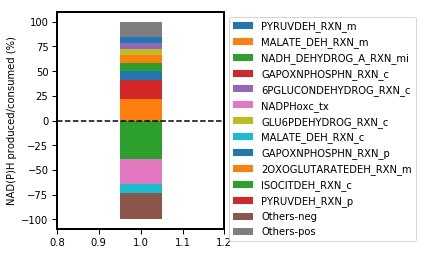

In [24]:
from functions3 import generateNADHNADPHbudget

generateNADHNADPHbudget(dividing_model2,solution.x_dict,outfile="/home/sanu/NADPHbudget_dividing",show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

In [25]:
def writeSolutionFluxesToFile(sol,outfile):
    import pandas as pd
    df = pd.DataFrame(data=sol.x_dict)
    df.to_csv(outfile)
    return

writeSolutionFluxesToFile(solution,"/home/sanu/DividingFluxes")

## Expanding cell - 2

In [26]:
#Estimate volume of cell wall in a cell
def estimateVcellwallSample(Vcell):
    #Vcell                           #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)                   #unit = m
    y = (8*(b**3))+(6*(Vcell**(2.0/3))*b)-(12*(Vcell**(1.0/3))*(b**2))
    return y

#Esimate cellulose content
def celluloseLevels(Vcell,Ncell):
    p_cellulose = 1.54*(10**6)              # unit = g/m3
    x = estimateVcellwallSample(Vcell)      # unit = m3/cell
    y = x*p_cellulose                       # unit = g/cell
    z = (y/180.16)*(10**6)*Ncell            # unit = umol/culture
    return z

#Estimate cell membrane of a cell
def estimateVcellmembrane(Vcell):
    #Vcell                       #unit = m3
    #cell wall thickness = 100 nm according to figure 19-68, https://www.ncbi.nlm.nih.gov/books/NBK26928/
    b=100*(10**-9)	
    #cell membrane thickness = 10 nm according to https://hypertextbook.com/facts/2001/JenniferShloming.shtml (see Hine, Robert. "Membrane." The Facts on File Dictionary of Biology. 3rd ed. New York: Checkmark, 1999: 198.)
    #c = 10*(10**-9)				#unit = m
    #cell membrane thickness = 4 nm BioNumbers
    c = 4*(10**-9)				#unit = m
    y = (8*(c**3))+(6*(Vcell**(2.0/3))*c)-(24*(b**2)*c)-(12*(c**2)*((Vcell**(1.0/3))-(2*b)))-(24*(Vcell**(1.0/3))*b*c)	#unit = m3
    return y

#Esimate phospholipid content
def phospholipidLevels(Vcell,Ncells):
    #dipalmitoyl phosphatidate  density = 0.928*(10**6)
    p_PA = 0.928*(10**6)              # unit = g/m3
    mw_PA = 646.88                    # unit = g/mol
    x = estimateVcellmembrane(Vcell)  # unit = m3/cell
    y = x*p_PA                        # unit = g/cell
    z = (y/mw_PA)*(10**6)*Ncells*(100.0/11.75)      # unit = umol/culture
    return z


#Estimate total protein content
def estimateProteinContent(Vcell,Ncell,ProtConc):
    #Vcell                           # unit = m3
    Vcyt = Vcell*(50.0/100.0)        # unit = m3/cell
    Vcyt_total = Vcyt*Ncell          # unit = m3/culture
    y = ProtConc*Vcyt_total*(10**6)        # unit = umol/culture
    return y



In [27]:

import math

#Assuming cell number = 0.1 to 0.4 million
Ncells = 1.45*(10**9)

#Beauvoit et al data
Vcell1 = estimateVcell(26)
Vcell2 = estimateVcell(27)
T = 26.63
Vcell1 = ((0.02894333/(0.00760074+(math.e**(-0.18324543*T))))-0.03277816)*(10**-12) # units = m3
Vcell_dash = (0.005303727*(math.e**(-0.18324543*T)))/((0.00760074+(math.e**(-0.18324543*T)))**2)
Vv = 0.853*(1-(math.e**((-2293-(T*24*60))/10633)))
Vc = (0.933 - Vv)/1.13

Processing GLC...


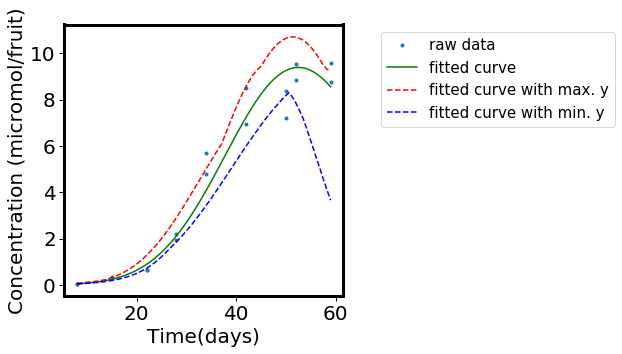

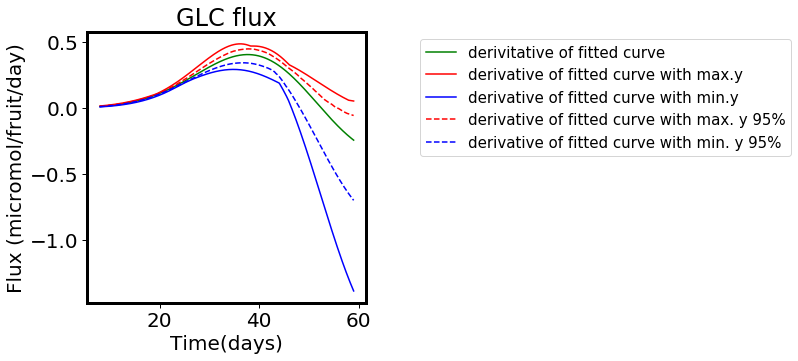

Processing FRU...


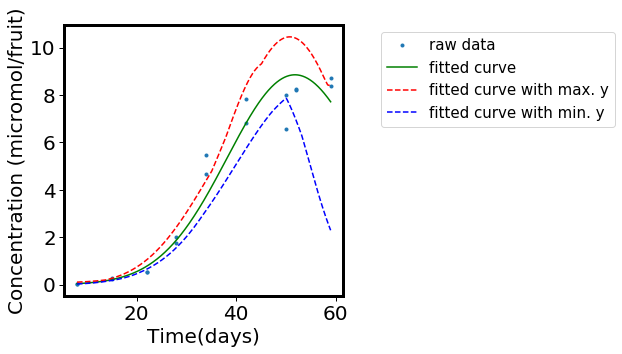

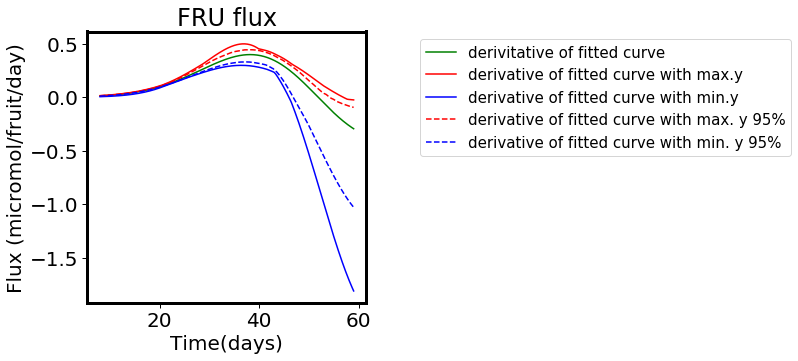

Processing SUC...


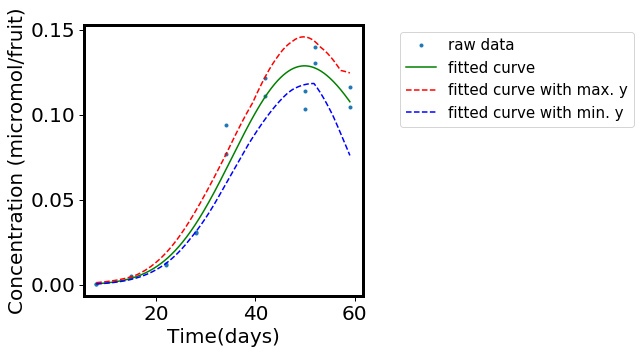

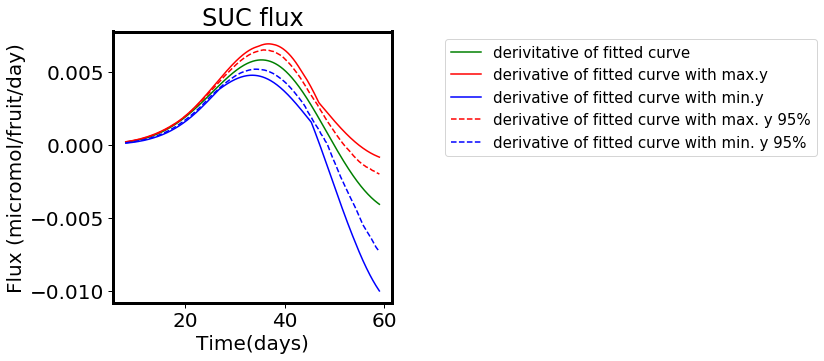

Processing MAL...


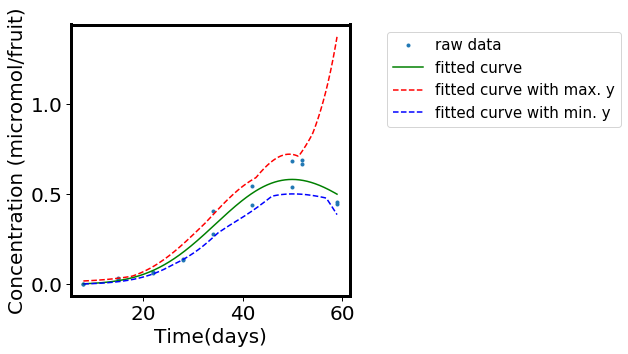

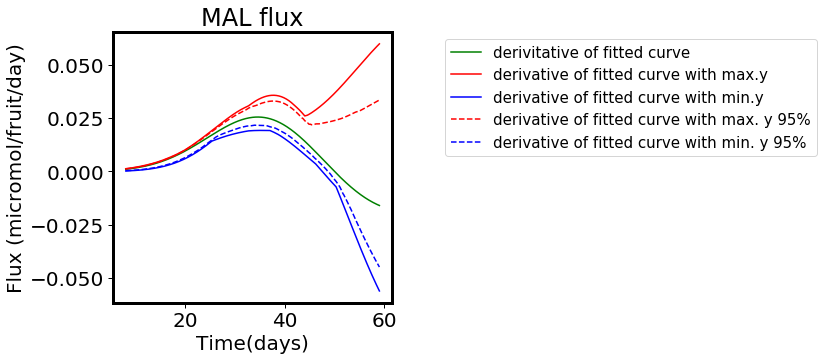

Processing CIT...


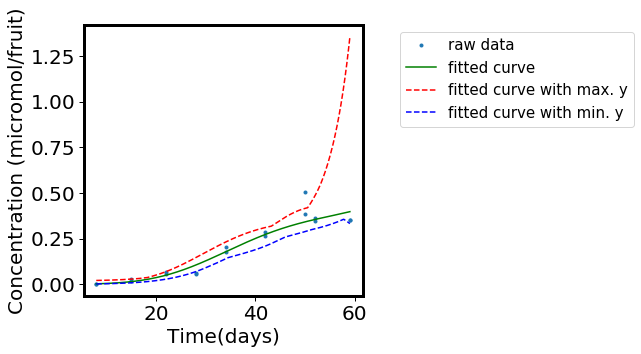

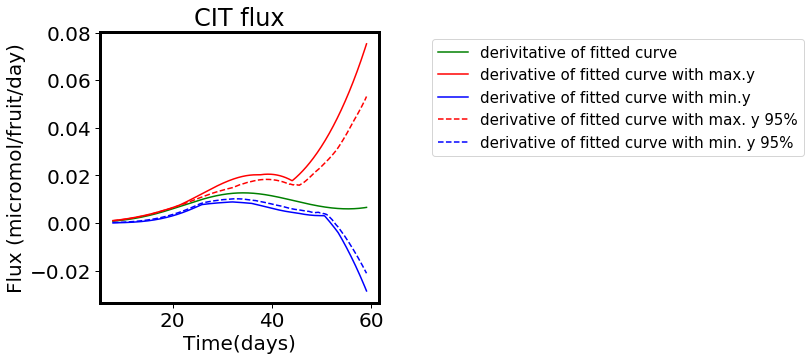

Processing L_ALPHA_ALANINE...


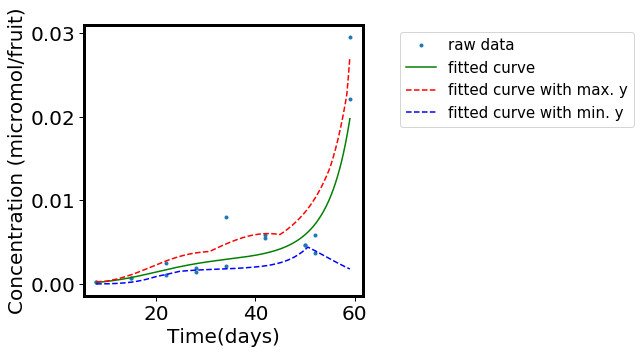

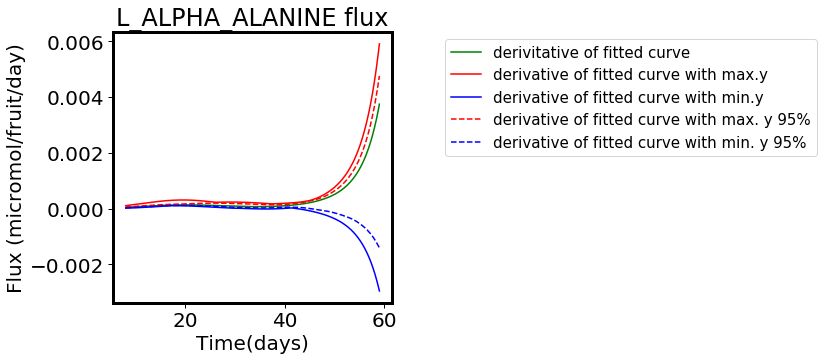

Processing ASN...


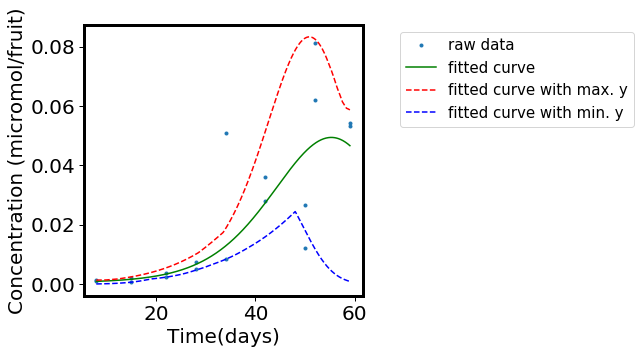

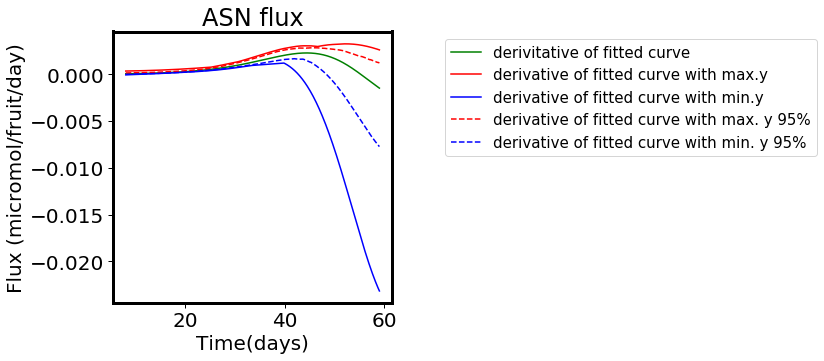

Processing L_ASPARTATE...


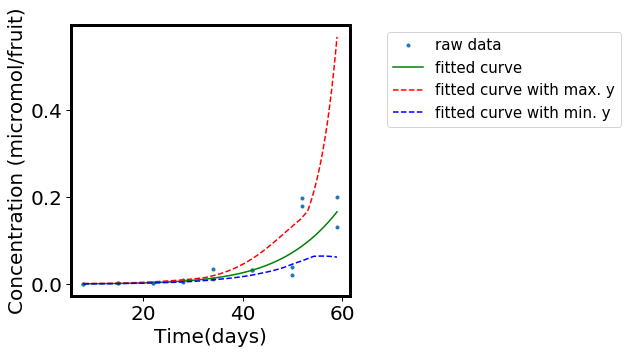

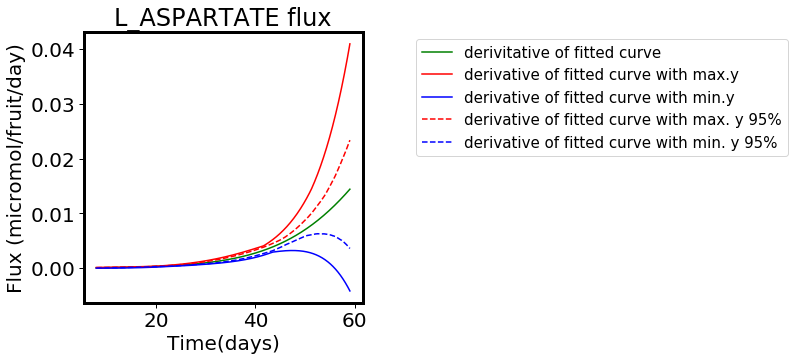

Processing GABA...


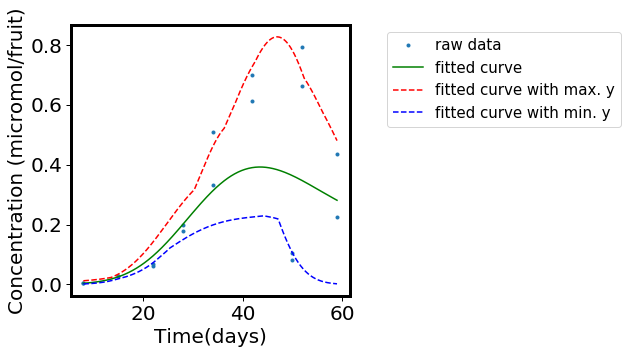

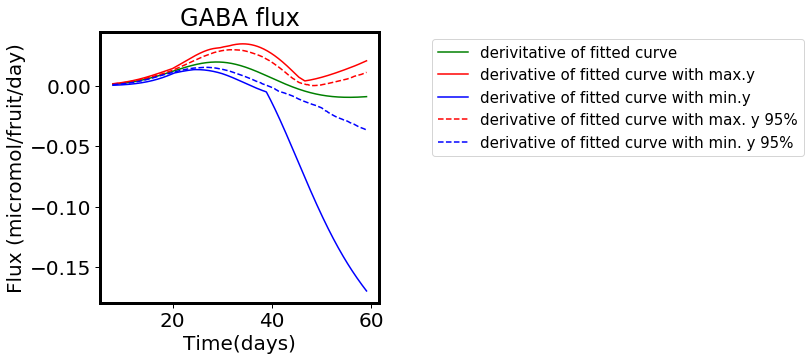

Processing GLT...


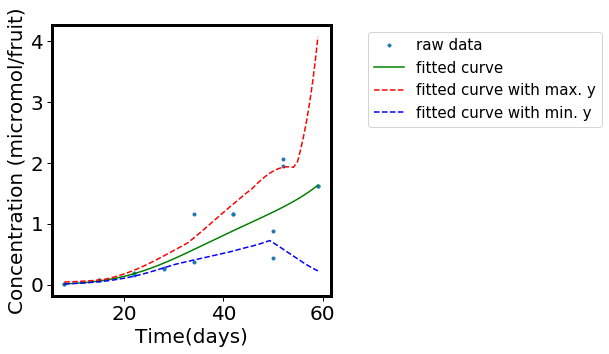

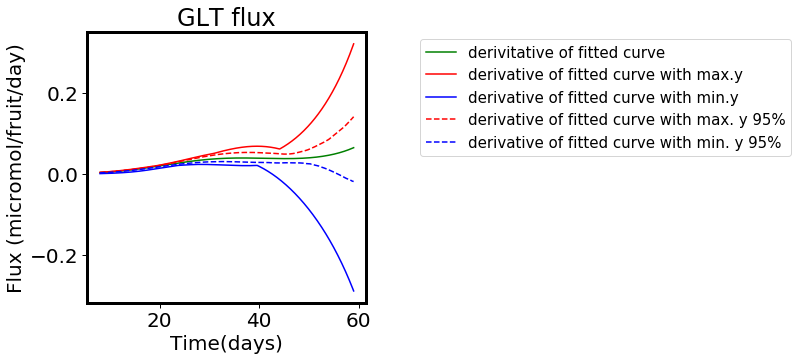

Processing GLN...


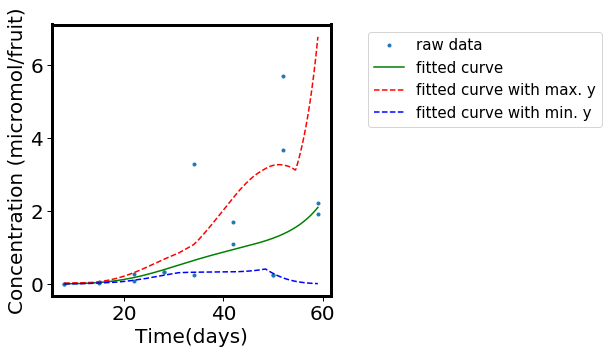

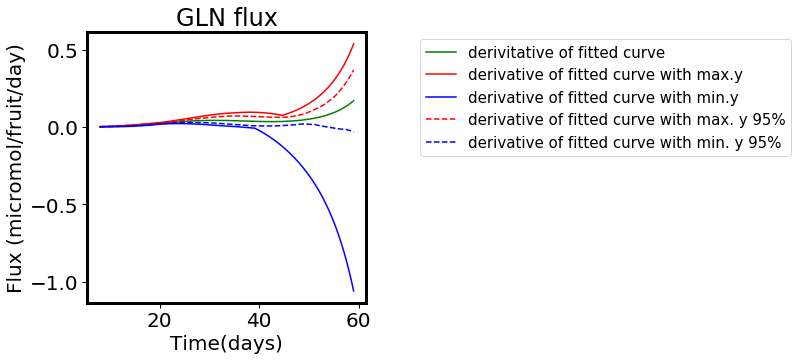

Processing GLY...


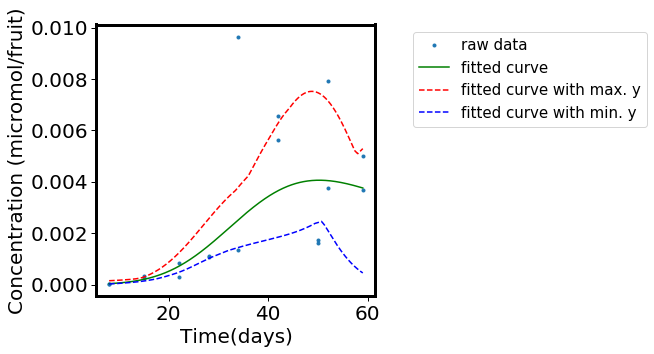

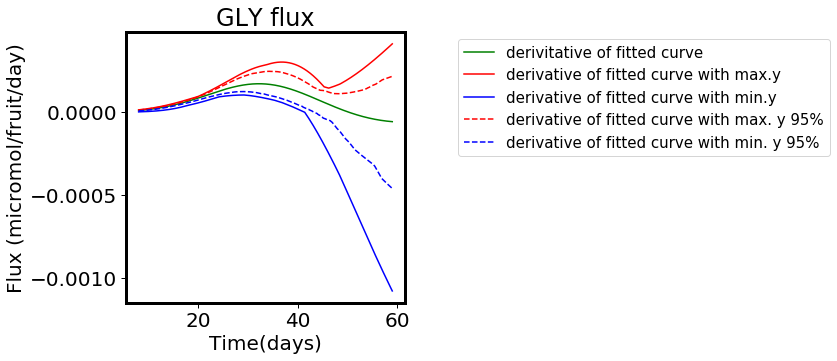

Processing ILE...


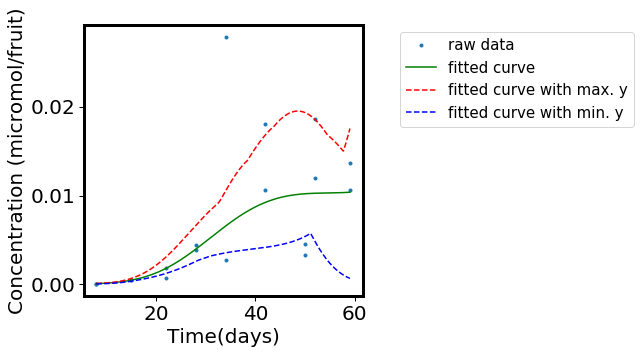

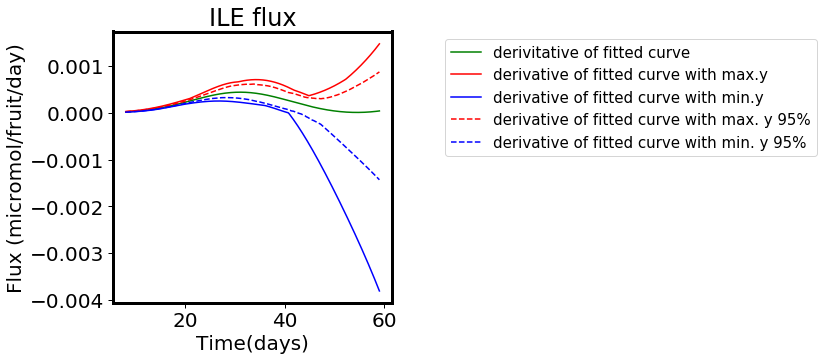

Processing LYS...


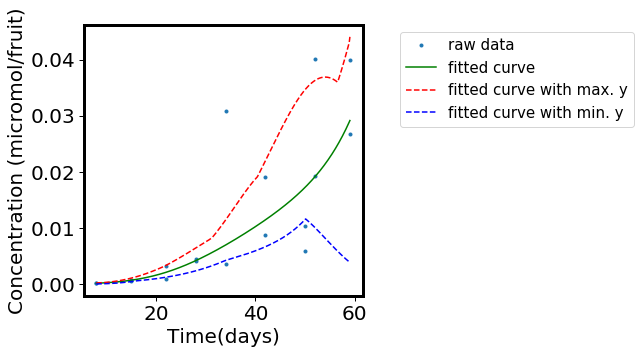

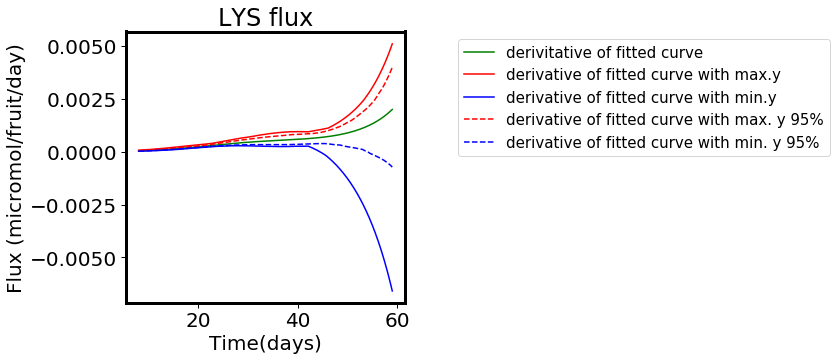

Processing MET...


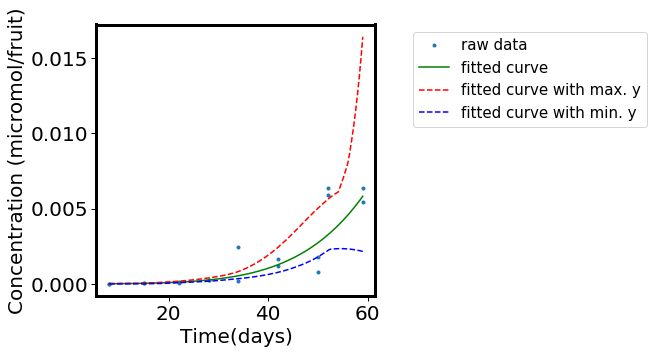

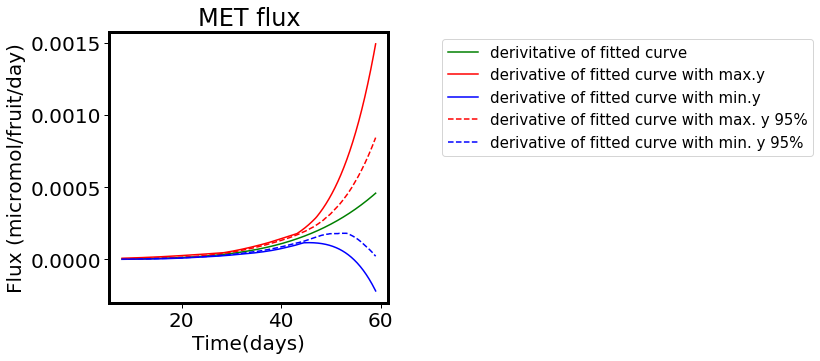

Processing PHE...


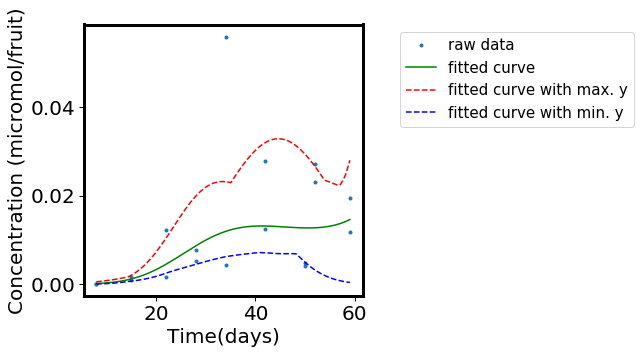

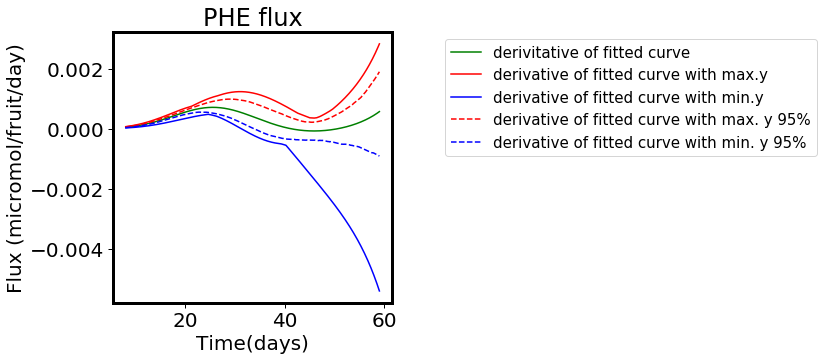

Processing PRO...


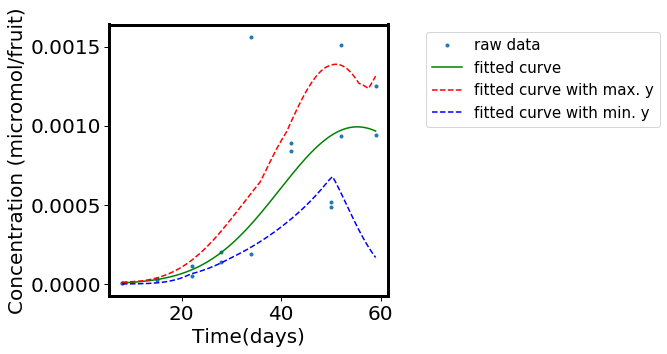

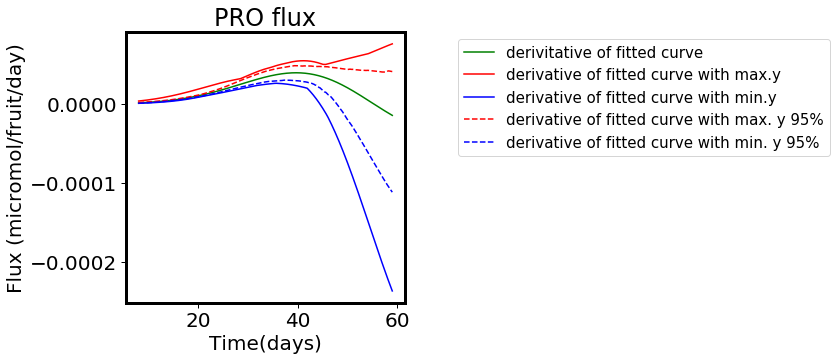

Processing SER...


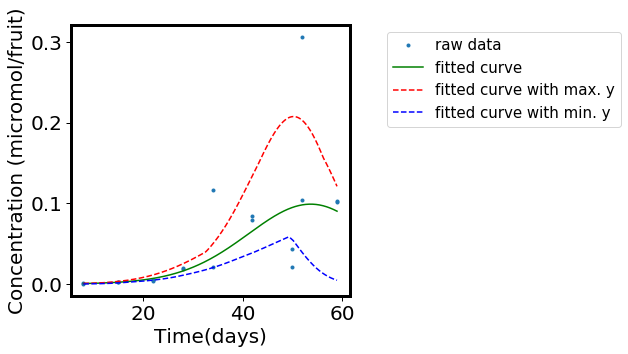

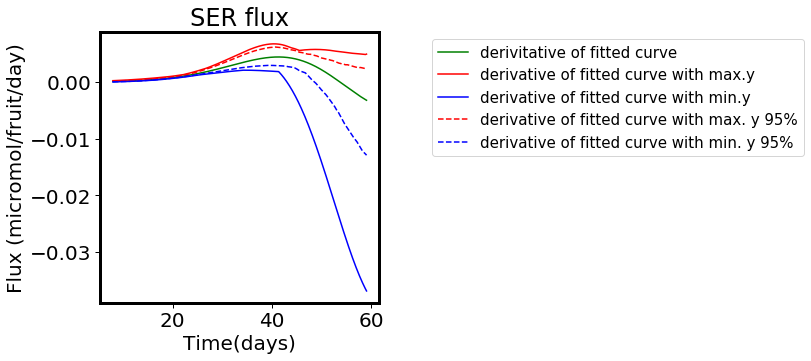

Processing THR...


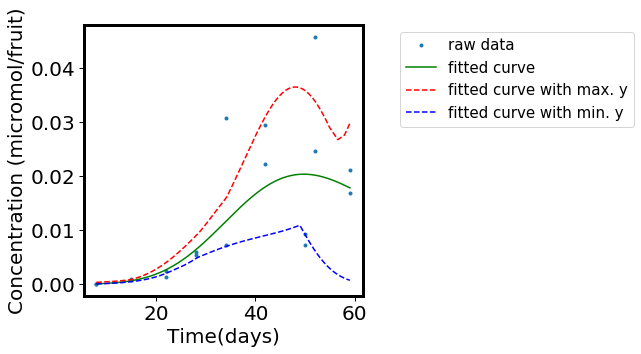

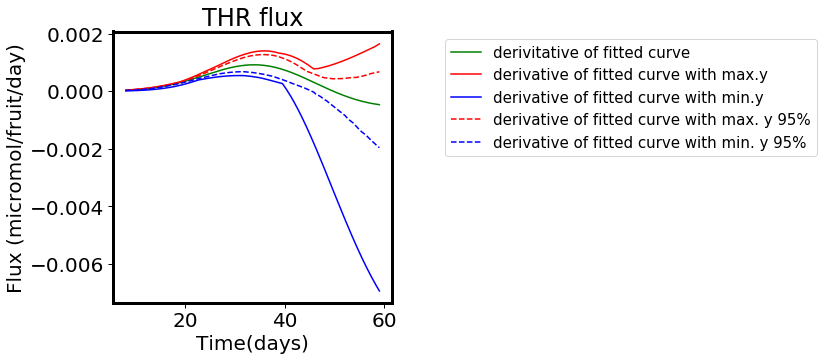

Processing TRP...


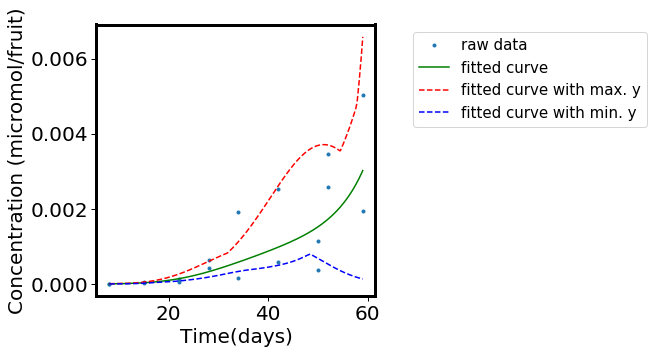

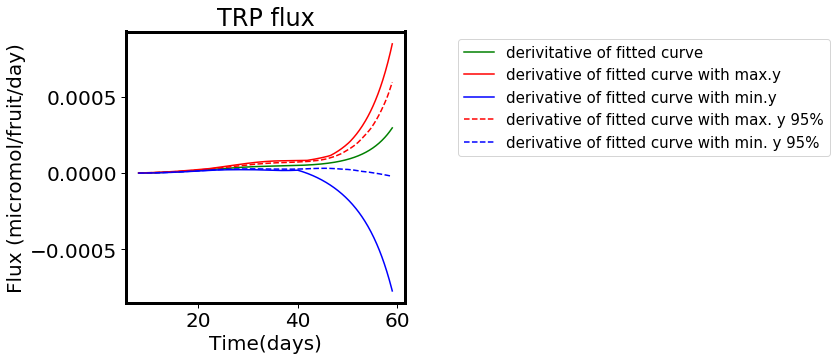

Processing TYR...


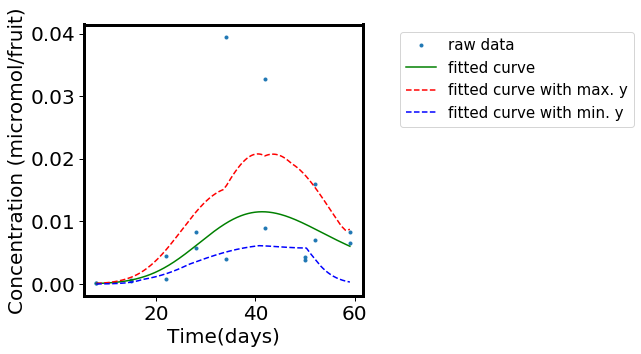

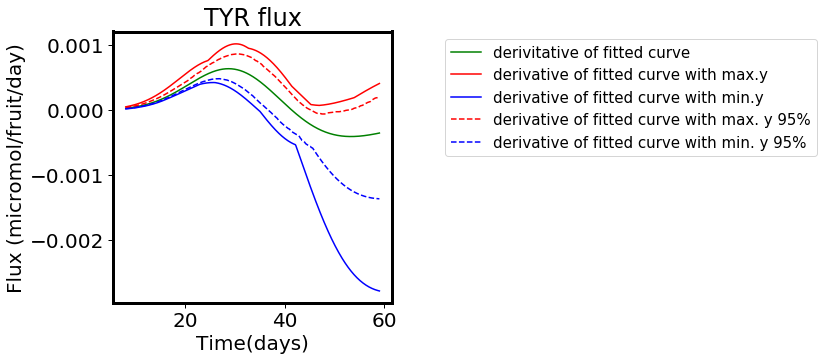

Processing VAL...


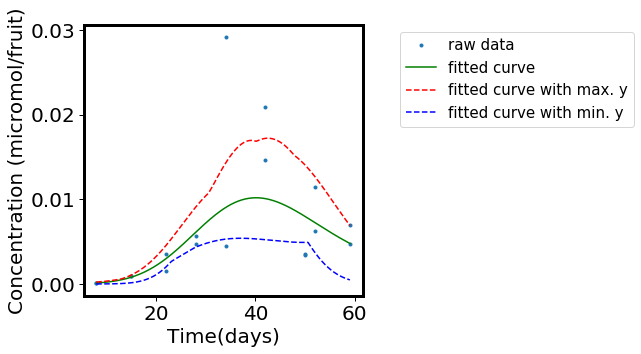

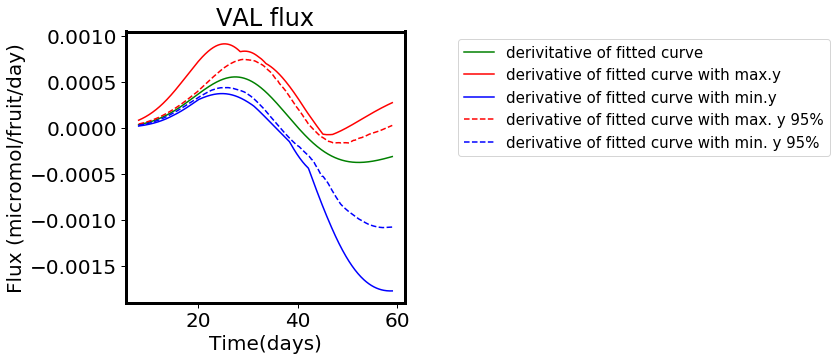

Processing FUM...


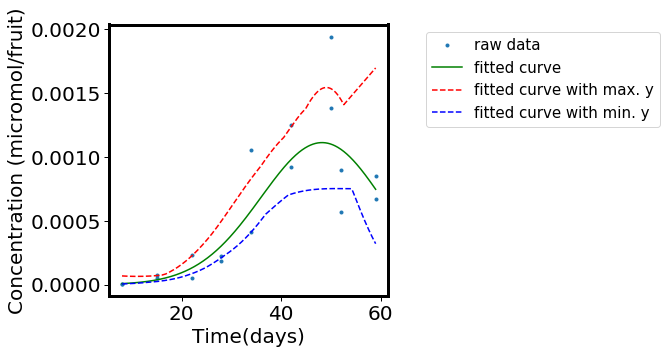

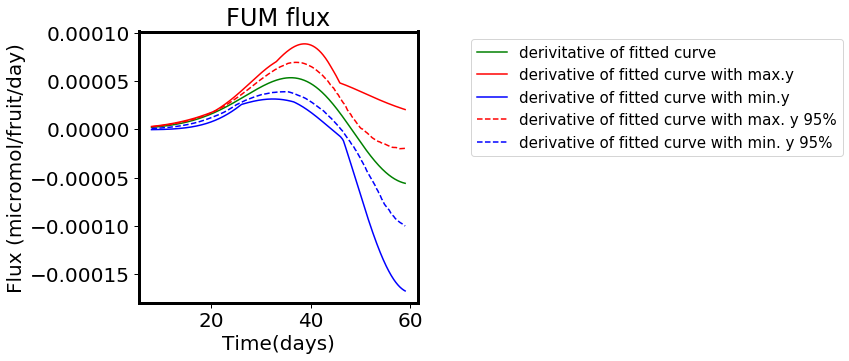

Processing STARCH...


In [28]:

#Jose's data for soluble metabolites
import numpy as np
from functions3 import generateBoundsFromBiomass
#Day time points of interest
DAA = [26,27]

mets = ("GLC","FRU","SUC","MAL","CIT","L_ALPHA_ALANINE","ASN","L_ASPARTATE","GABA","GLT","GLN","GLY","ILE","LYS","MET","PHE","PRO","SER","THR","TRP","TYR","VAL","FUM")
#mets = ("GLC",)
dfile="/home/sanu/JoseData_soluble_100818.csv"
Nsampl= 1000
Ssampl= 0.80

conc = dict()
conc_min = dict()
conc_max = dict()
flux_max = dict()
flux_min = dict()

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=True,degree=3,Ssampling=Ssampl,start=8,stop=59)


mets = ("STARCH",)
dfile="/home/sanu/JoseData_starch_protein_150818.csv"
Nsampl= 1000
Ssampl= 0.80

for met in mets:
  print "Processing "+met+"..."
  [conc[met],conc_max[met],conc_min[met],flux_max[met],flux_min[met]]=generateBoundsFromBiomass(datafile = dfile,met=met,Nsampling=Nsampl,DPA=DAA,show_plots=False,degree=3,Ssampling=Ssampl,start=8,stop=59)



In [29]:
import pandas as pd
df = pd.DataFrame(data={"mets":[],"amount":[]})
for met in conc.keys():
    df = df.append({"mets":met,"amount":conc[met][1]-conc[met][0]},ignore_index=True)
df

,amount,mets
0,0.000397,ILE
1,0.003990,SUC
2,0.039066,GLN
3,0.236108,GLC
4,0.000148,GLY
5,0.010235,CIT
6,0.000033,FUM
7,0.031649,GLT
8,0.001792,SER
9,0.000381,LYS


Maintenance costs estimated to be same as in dividing cells

In [30]:
Maint = 0.062 #mmol/mL

In [31]:


#import sbml file
expanding_model2 = io.sbml.create_cobra_model_from_sbml_file("PlantCoreMetabolism_v1_2_3.xml")

#only glucose as nutrient
expanding_model2.reactions.get_by_id("GLC_tx").upper_bound = 1000
expanding_model2.reactions.get_by_id("GLC_tx").lower_bound = 0
expanding_model2.reactions.get_by_id("Sucrose_tx").upper_bound = 0
expanding_model2.reactions.get_by_id("Photon_tx").upper_bound = 0

#Setting up maintenance
met=Metabolite("ATPNAPDH_maintenance_constraint")
expanding_model2.reactions.get_by_id("ATPase_tx").add_metabolites({met:-1})
expanding_model2.reactions.get_by_id("NADPHoxc_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxp_tx").add_metabolites({met:3})
expanding_model2.reactions.get_by_id("NADPHoxm_tx").add_metabolites({met:3})
#maintenance from expanding cells
expanding_model2.reactions.get_by_id("ATPase_tx").lower_bound = Maint
expanding_model2.reactions.get_by_id("ATPase_tx").upper_bound = Maint

#Create a Protein_b metabolites
rxn = expanding_model2.reactions.get_by_id("Biomass_tx")
for met in ["Ca_b","K_b","Mg_b"]:
    met = expanding_model2.metabolites.get_by_id(met)
    coeff = rxn.metabolites.get(met)
    rxn.add_metabolites({met:-1*coeff})
met = Metabolite("Protein_b",name="Protein_biomass")
rxn.add_metabolites({met:1})


In [32]:
expanding_model2.reactions.get_by_id("MAL_CIT_vc").reaction

'CIT_c + 0.7 MAL_v + 0.5 PROTON_v + 0.3 aMAL_v --> 0.5 CIT_v + MAL_c + 0.3 PROTON_c + 0.5 aCIT_v'

In [33]:


#Assuming cell size increases to 4x the orignal volume
#a1 = 0.2*(10**(-4))
#Vcell1 = a1**3
#Vcell2 = Vcell1*4
#Ncells = 10**5
cellulose1 = celluloseLevels(Vcell1,Ncells)
cellulose2 = celluloseLevels(Vcell2,Ncells)
cellulose_acc = (cellulose2 - cellulose1)/10**6

lipid1 = phospholipidLevels(Vcell1,Ncells)
lipid2 = phospholipidLevels(Vcell2,Ncells)
lipid_acc = (lipid2 - lipid1)/10**6

ProteinConc = 2.5*(10**6)                             # unit = proteins/um3
ProteinConc = ProteinConc*(10**18)                    # unit = proteins/m3
Avagadro_N = 6*(10**23)
ProteinConc = ProteinConc*(1.0/Avagadro_N)            # unit = mol/m3
protein1 = estimateProteinContent(Vcell1,Ncells,ProteinConc)
protein2 = estimateProteinContent(Vcell2,Ncells,ProteinConc)
protein_acc = (protein2 - protein1)/10**6

#Add expanding cell biomass drain
rxn = Reaction("Biomass_expanding_cell")
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Cellulose_b"):-1*cellulose_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1*lipid_acc})
rxn.add_metabolites({expanding_model2.metabolites.get_by_id("Protein_b"):-1*protein_acc})
expanding_model2.add_reaction(rxn)
rxn.lower_bound = 1
rxn.upper_bound = 1

In [34]:
cellulose_acc

0.002578953271116319

In [35]:
#Setting up osmotic constraints
#solutes=["SUCROSE","MAL","NITRATE","AMMONIUM","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM","MGII","KI","CAII"]
#solutes=["SUCROSE","MAL","CIT","GLN","ASN","SER","GLY","THR","L_ALPHA_ALANINE","4_AMINO_BUTYRATE","VAL","ILE","PHE","LEU","LYS","ARG","L_ASPARTATE","GLT","HIS","MET","PRO","TRP","TYR","CYS","GLC","FRU","FUM"]
#solutes=["SUCROSE","GLC","FRU"]
soluteTranslate={"GABA":"4_AMINO_BUTYRATE","SUC":"SUCROSE","sCIT_b":"CIT","sMAL_b":"MAL","sSUC_b":"SUC","sFUM_b":"FUM","sASP_b":"L_ASPARTATE","sGLU_b":"GLT","sGLN_b":"GLN","sGABA_b":"4_AMINO_BUTYRATE","sALA_b":"L_ALPHA_ALANINE"}
VO = Metabolite("VO",name="vacuolar osmolytes")
VC = Metabolite("VC",name="vacuolar charge")
CO = Metabolite("CO",name="cytosolic osmolytes")
CC = Metabolite("CC",name="cytosolic charge")

rxn = Reaction("soluble_biomass")
expanding_model2.add_reaction(rxn)
for met2 in df["mets"]:
    if met2 == "STARCH":
        continue
    if met2 in soluteTranslate.keys():
        met = soluteTranslate[met2]
    else:
        met = met2
    METB = Metabolite(met+"_b")
    if met=="HIS":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="MAL":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.7)+(aMETV.charge*0.3)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.7,aMETV:-0.3,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="CIT":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.5)+(aMETV.charge*0.5)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.5,aMETV:-0.5,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="FUM":
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        aMETV = expanding_model2.metabolites.get_by_id("a"+met+"_v")
        charge = (METV.charge*0.92)+(aMETV.charge*0.08)
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-0.92,aMETV:-0.08,VC:charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    elif met=="SUC":
        print("Skipping SUC_v")
    else:
        METV = expanding_model2.metabolites.get_by_id(met+"_v")
        rxn = Reaction(met+"_v_biomass")
        rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
        expanding_model2.add_reaction(rxn)
    ##############
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = expanding_model2.reactions.get_by_id("soluble_biomass")
    rxn.add_metabolites({METB:-1*float(df["amount"][df["mets"]==met2])})

for met in ["NITRATE","AMMONIUM","MGII","KI","CAII"]:
    METB = Metabolite(met+"_b")
    METV = expanding_model2.metabolites.get_by_id(met+"_v")
    rxn = Reaction(met+"_v_biomass")
    rxn.add_metabolites({METV:-1,VC:METV.charge,VO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    METC = expanding_model2.metabolites.get_by_id(met+"_c")
    rxn = Reaction(met+"_c_biomass")
    rxn.add_metabolites({METC:-1,CC:METC.charge,CO:1,METB:1})
    expanding_model2.add_reaction(rxn)
    
    rxn = Reaction(met+"_b_biomass")
    rxn.add_metabolites({METB:-1})
    expanding_model2.add_reaction(rxn)

rxn = Reaction("VacCytRatio")
WO = Metabolite("TotalSolute")
rxn.add_metabolites({CO:-1,VO:-1*(Vv/Vc),WO:1+(Vv/Vc)})
rxn.lower_bound = 0
rxn.upper_bound = 1000
expanding_model2.add_reaction(rxn)

C_cell = 275           #Almeida and Huber 1999; units = mOsmol/kg ~ mmol/L
C_cell = 275           #units = mol/m3

rxn = Reaction("TotalSoluteConstraint")
rxn.add_metabolites({WO:-1})
rxn.lower_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
rxn.upper_bound = (C_cell*Vcell2*Ncells - C_cell*Vcell1*Ncells)
expanding_model2.add_reaction(rxn)

In [37]:
expanding_model2.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=0
expanding_model2.reactions.get_by_id("soluble_biomass").objective_coefficient=1
expanding_model2.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(expanding_model2)
print("Minimal glucose uptake rate = "+str(expanding_model2.reactions.get_by_id("GLC_tx").x)+" mol/m3")
print("Minimal glucose uptake rate = "+str(expanding_model2.reactions.get_by_id("GLC_tx").x*expanding_model2.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")


Minimal glucose uptake rate = 0.0322803229108 mol/m3
Minimal glucose uptake rate = 5.81548998068 g/L


In [38]:
for rxn in expanding_model2.reactions:
    if (len(rxn.reactants)==0 or len(rxn.products)==0) and round(abs(rxn.x),6)>0:
        print rxn.reaction+"\t"+str(rxn.x)

PROTON_e --> 	0.010533095161
 <=> WATER_e	-0.0468157980054
 <=> CARBON_DIOXIDE_e	-0.0317258186702
 <=> OXYGEN_MOLECULE_e	0.0320258134764
 <=> Pi_e	0.00014721857644
 <=> MGII_e	0.00184522437561
 <=> SULFATE_e	2.88437098125e-05
 <=> AMMONIUM_e	0.00658777231853
 --> GLC_e	0.0322803229108
0.00257895327112 Cellulose_b + 0.00014721857644 L_PHOSPHATIDATE_p + 0.000194906179161 Protein_b --> 	1.0
0.0189185726551 4_AMINO_BUTYRATE_b + 0.000632941080018 ASN_b + 0.0102350770683 CIT_b + 0.214339388118 FRU_b + 3.34564057967e-05 FUM_b + 0.236108350161 GLC_b + 0.0390662201806 GLN_b + 0.0316487664356 GLT_b + 0.000147651223606 GLY_b + 0.000396830361715 ILE_b + 0.000380881600325 LYS_b + 0.000111957196487 L_ALPHA_ALANINE_b + 0.000667221199589 L_ASPARTATE_b + 0.0188430061537 MAL_b + 2.81876543648e-05 MET_b + 0.000707758543248 PHE_b + 2.12127482553e-05 PRO_b + 0.00179155740668 SER_b + 0.00399046521043 SUCROSE_b + 0.000699347414995 THR_b + 3.47922464603e-05 TRP_b + 0.000612520979419 TYR_b + 0.000552162760381 

In [39]:
def writeSolutionFluxesToFile(sol,outfile,model):
    import pandas as pd
    rxnList = list()
    eqnList = list()
    fluxList = list()
    EClist = list()
    for rxn in model.reactions:
        rxnList.append(rxn.id)
        eqnList.append(rxn.reaction)
        if not "PROTEIN CLASS" in rxn.notes.keys():
            EClist.append("")
        else:
            EClist.append(rxn.notes.get("PROTEIN CLASS")[0])
        fluxList.append(sol.x_dict.get(rxn.id))
    df = pd.DataFrame(data={"ID":rxnList,"EC number":EClist,"reaction":eqnList,"flux":fluxList})
    df = df[['ID','EC number', 'reaction', 'flux']]
    df.to_csv(outfile)
    return

writeSolutionFluxesToFile(solution,"ExpandingFluxes.csv",expanding_model2)

In [40]:
rxn = expanding_model2.reactions.get_by_id("soluble_biomass")
total2 = 0
for met in rxn.metabolites:
    if met.id[len(met.id)-2:] == "_b":
        MET = dividing_model2.metabolites.get_by_id(met.id[:len(met.id)-2]+"_c")
    else:
        MET=met
    print met.id+"\t"+str(float(MET.formula.split("C")[1].split("H")[0])*abs(rxn.metabolites.get(met))*rxn.x)
    total2 = total2 + float(MET.formula.split("C")[1].split("H")[0])*abs(rxn.metabolites.get(met))*rxn.x
print total2
    

ASN_b	0.000104254980003
FRU_b	0.0529574141909
PHE_b	0.00026230173547
SER_b	0.000221322474757
VAL_b	0.000113686959496
PRO_b	4.36757605678e-06
FUM_b	5.51077663847e-06
GLC_b	0.0583359307088
GLT_b	0.00651628883006
4_AMINO_BUTYRATE_b	0.0031161753852
ILE_b	9.80459541917e-05
MET_b	5.8036668714e-06
MAL_b	0.00310372843817
TRP_b	1.57597270142e-05
GLN_b	0.00804349751557
SUCROSE_b	0.0019718701338
TYR_b	0.000227005830514
THR_b	0.000115193108912
CIT_b	0.00252880826218
LYS_b	9.41054504413e-05
GLY_b	1.21601961465e-05
L_ASPARTATE_b	0.000109901434772
L_ALPHA_ALANINE_b	1.38307841552e-05
0.13797696412


### When organic content maximized and SOF is minimized

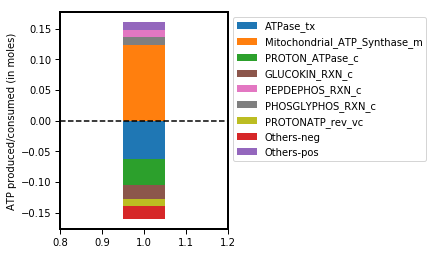

In [42]:
from SweetloveGroup.analysis import *

generateATPbudget(expanding_model2,solution.x_dict,outfile="/home/sanu/ATPbudget_expanding26_max.csv",show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

In [43]:
0.007+0.004306+0.007737+0.063440+0.065

0.147483

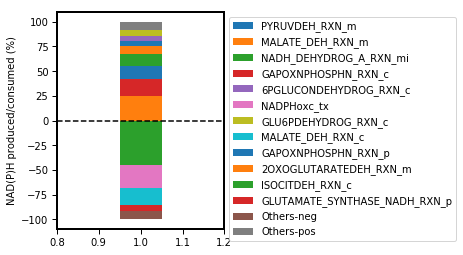

In [44]:
from SweetloveGroup.analysis import *

generateNADHNADPHbudget(expanding_model2,solution.x_dict,outfile="/home/sanu/NADPHbudget_expanding26_max",show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

### When SOF is minimized

In [47]:
model = expanding_model2.copy()
model.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient=1
model.reactions.get_by_id("soluble_biomass").objective_coefficient=0
model.reactions.get_by_id("GLC_tx").objective_coefficient=0

solution = flux_analysis.parsimonious.pfba(model)
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x)+" mol/m3")
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*expanding_model2.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")



Minimal glucose uptake rate = 0.0089536030658 mol/m3
Minimal glucose uptake rate = 1.61304423949 g/L


In [48]:
met = model.metabolites.Protein_b
met2 = dividing_model2.metabolites.Protein_b
Cnum = float(met2.formula.split("C")[1].split("H")[0])
print Cnum
R = model.reactions.get_by_id("GLC_ec")
for rxn in met.reactions:
    if round(rxn.x,9)==0:
        continue
    print rxn.id+"\t"+str((rxn.x/R.x)*Cnum)
    #print rxn.x*rxn.metabolites.get(met)

17.2020450391
Biomass_expanding_cell	1921.24275699
Biomass_tx	0.374462085004


In [49]:
(-2.28079382974+0.179304430303)-2.20014370119

-4.301633100627

In [50]:
total = 0
for rxn in ["CHORISMATEMUT_RXN_p","PSERTRANSAM_RXN_p","ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p","HISTPRATPHYD_RXN_p","ACETOLACTSYN_RXN_p"]:
    rxn = model.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/model.reactions.get_by_id("GLC_tx").x)
print(total)

0.307076083422


In [51]:
total = 0
for rxn in ["GLUTAMINESYN_RXN_m"]:
    rxn = model.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/model.reactions.get_by_id("GLC_tx").x)
print(total)

0.00512415000939


In [52]:
total = 0
for rxn in ["ALANINE_AMINOTRANSFERASE_RXN_c","PEPCARBOX_RXN_c"]:
    rxn = model.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/model.reactions.get_by_id("GLC_tx").x)
print(total)

0.282675605776


In [53]:
tot = 0
R = model.reactions.get_by_id("GLC_tx")
for rxn in model.reactions.query("_c_biomass"):
    #print rxn.reaction
    if "NITRATE" in rxn.id or "AMMONIUM" in rxn.id or "MGII" in rxn.id or "KI" in rxn.id or "CAII" in rxn.id:
        Cnum = 1
    else:
        for met in rxn.reactants:
            if "VC" in met.id or "CC" in met.id:
                continue
            else:
                Cnum = float(met.formula.split("C")[1].split("H")[0])
                break
    #if round(rxn.x,7)==0:
    #    continue
    print rxn.id+"\t"+str((rxn.x/R.x)*Cnum)
    if "GLC" in rxn.id or "FRU" in rxn.id or "SUC" in rxn.id or "CIT" in rxn.id or "FUM" in rxn.id or "MAL" in rxn.id or "NITRATE" in rxn.id or "AMMONIUM" in rxn.id or "MGII" in rxn.id or "KI" in rxn.id or "CAII" in rxn.id:
        continue
    else:
        tot =tot+((rxn.x/R.x)*Cnum)
    #print rxn.id+"\t"+str((rxn.x))

ILE_c_biomass	-8.04134629735e-18
SUCROSE_c_biomass	-1.11799000876e-16
GLN_c_biomass	-6.9117871743e-16
GLC_c_biomass	0.0
GLY_c_biomass	-5.59441943442e-19
CIT_c_biomass	0.0
FUM_c_biomass	-2.4837501692e-19
GLT_c_biomass	7.38546831948e-16
SER_c_biomass	-1.0182161037e-17
LYS_c_biomass	3.12863027751e-18
PRO_c_biomass	0.0
L_ASPARTATE_c_biomass	-5.05612504234e-18
ASN_c_biomass	-5.10911980096e-18
L_ALPHA_ALANINE_c_biomass	-6.3629900981e-19
VAL_c_biomass	-6.38639318115e-18
THR_c_biomass	-5.29957378518e-18
FRU_c_biomass	0.0
TRP_c_biomass	-7.25041948559e-19
PHE_c_biomass	-8.89907380162e-18
MET_c_biomass	-2.67003478768e-19
MAL_c_biomass	0.0
TYR_c_biomass	-1.1440157562e-17
4_AMINO_BUTYRATE_c_biomass	-1.43362754399e-16
NITRATE_c_biomass	0.136110934935
AMMONIUM_c_biomass	0.136110934935
MGII_c_biomass	1.50294680627e-16
KI_c_biomass	0.0
CAII_c_biomass	0.0


In [54]:
dividing_model2.metabolites.Protein_b.formula

'C17.2020450391H25.9492553613O5.7497158698N4.9536245179S0.1420323181'

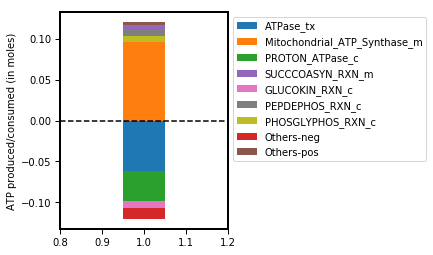

In [55]:
from SweetloveGroup.analysis import *

generateATPbudget(expanding_model2,solution.x_dict,outfile="/home/sanu/ATPbudget_expanding26_minSOF.csv",show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

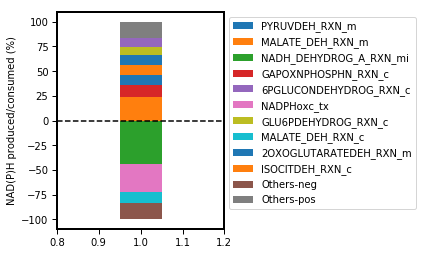

In [56]:
from SweetloveGroup.analysis import *

generateNADHNADPHbudget(expanding_model2,solution.x_dict,outfile="/home/sanu/NADPHbudget_expanding26_minSOF",show_plot=True,percentage=True,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

In [57]:
xlist = list()
ylist = list()

for i in [0,0.25,0.5,0.75,1,1.25,1.50,1.75,2]:
    xlist.append((i)*100)
    model = expanding_model2.copy()
    t = model.reactions.get_by_id("ATPase_tx").lower_bound
    model.reactions.get_by_id("ATPase_tx").lower_bound = (i*t)
    model.reactions.get_by_id("ATPase_tx").upper_bound = (i*t)
    solution = flux_analysis.parsimonious.pfba(model)
    print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*model.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")
    ylist.append(model.reactions.get_by_id("GLC_tx").x*model.metabolites.get_by_id("GLC_c").formula_weight)
    
    


    

Minimal glucose uptake rate = 5.19826078806 g/L
Minimal glucose uptake rate = 5.3517303641 g/L
Minimal glucose uptake rate = 5.5048853685 g/L
Minimal glucose uptake rate = 5.66018767459 g/L
Minimal glucose uptake rate = 5.81548998068 g/L
Minimal glucose uptake rate = 5.97079228677 g/L
Minimal glucose uptake rate = 6.12609459286 g/L
Minimal glucose uptake rate = 6.28139689895 g/L
Minimal glucose uptake rate = 6.43669920503 g/L


In [58]:
model = dividing_model2.copy()
#model.reactions.get_by_id("ATPase_tx").lower_bound = 0
#model.reactions.get_by_id("ATPase_tx").upper_bound = 0
model.reactions.unlProtHYPO_c.lower_bound= -1000
solution = flux_analysis.parsimonious.pfba(model)
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*model.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")


model = expanding_model2.copy()
model.reactions.get_by_id("ATPase_tx").lower_bound = dividing_model2.reactions.get_by_id("ATPase_tx").lower_bound
model.reactions.get_by_id("ATPase_tx").upper_bound = dividing_model2.reactions.get_by_id("ATPase_tx").lower_bound
model.reactions.unlProtHYPO_c.lower_bound= -1000
solution = flux_analysis.parsimonious.pfba(model)
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*model.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")

Minimal glucose uptake rate = 3.55350153585 g/L
Minimal glucose uptake rate = 5.76409239054 g/L


In [59]:
expanding_model2.reactions.get_by_id("ATPase_tx").lower_bound

0.062

In [60]:
print("Minimal glucose uptake rate = "+str(model.reactions.get_by_id("GLC_tx").x*model.metabolites.get_by_id("GLC_c").formula_weight)+" g/L")
met = model.metabolites.get_by_id("PROTON_e")
[(rxn.id,rxn.x*rxn.metabolites.get(met)) for rxn in met.reactions]

Minimal glucose uptake rate = 5.76409239054 g/L


[('Pi_ec', -0.00044165572932104187),
 ('Nitrate_ec', -0.0),
 ('Phloem_output_tx', -0.0),
 ('SO4_ec', -8.65311294374713e-05),
 ('K_ec', -0.0),
 ('H_tx', -0.0),
 ('Sucrose_ec', -0.0),
 ('GLC_ec', -0.03199502780893144),
 ('PROTON_ATPase_c', 0.032523214667690266)]

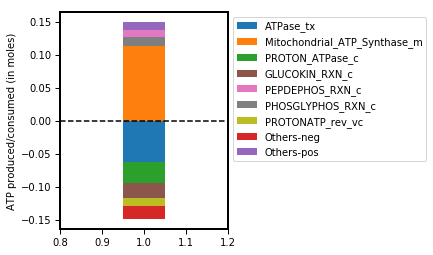

In [61]:
generateATPbudget(model,solution.x_dict,outfile="",show_plot=True,percentage=False,day_or_night_tag="",save_plot_to="temp.png",colourDict={})

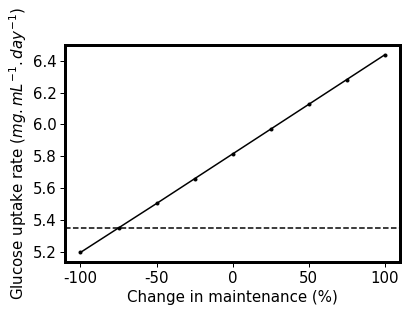

In [62]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15}) #sets a global fontsize
plt.rcParams['xtick.major.size'] = 5 # adjusts tick line length and width
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['axes.linewidth'] = 3 # makes axes line thicker

plt.plot(xlist,ylist,"k.-")
plt.axhline(5.34966350062,linestyle="--",color="black")
plt.xlabel("Change in maintenance (%)")
plt.ylabel("Glucose uptake rate ($mg.mL^{-1}.day^{-1}$)")
plt.xticks([0,50,100,150,200],[-100,-50,0,50,100])
plt.show()

In [63]:
met = expanding_model2.metabolites.get_by_id("PROTON_e")
[(rxn.id,rxn.x*rxn.metabolites.get(met)) for rxn in met.reactions]

[('H_tx', -0.010533095161030825),
 ('GLC_ec', -0.032280322910801296),
 ('Nitrate_ec', -0.0),
 ('Pi_ec', -0.0004416557293214496),
 ('K_ec', -0.0),
 ('Phloem_output_tx', -0.0),
 ('Sucrose_ec', -0.0),
 ('PROTON_ATPase_c', 0.04334160493059104),
 ('SO4_ec', -8.653112943747046e-05)]

In [64]:
def writeSolutionFluxesToFile(sol,outfile):
    import pandas as pd
    df = pd.DataFrame(data=sol.x_dict)
    df.to_csv(outfile)
    return

writeSolutionFluxesToFile(solution,"/home/sanu/ExpandingFluxes")

In [65]:
met = expanding_model2.metabolites.GLC_c
R = expanding_model2.reactions.get_by_id("GLC_ec")
for rxn in met.reactions:
    if round(rxn.x,9)==0:
        continue
    print rxn.id+"\t"+str((rxn.x/R.x)*6)
    #print rxn.x*rxn.metabolites.get(met)

GLC_ec	6.0
GLC_PROTON_rev_vc	1.72514784233
GLC_c_biomass	0.082019045996
GLUCOKIN_RXN_c	4.19283311168


In [66]:
-1*(-1.56701108653+0.554646666185)+1.03972819428

2.052092614625

In [67]:
met = expanding_model2.metabolites.get_by_id("L_PHOSPHATIDATE_p")
R = expanding_model2.reactions.get_by_id("GLC_ec")
for rxn in met.reactions:
    if round(rxn.x,5)==0:
        continue
    print rxn.id+"\t"+str((rxn.x/R.x)*6)
    #print rxn.x*rxn.metabolites.get(met)

Biomass_expanding_cell	185.871746592
1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p	0.0273637739338


In [68]:
met = expanding_model2.metabolites.get_by_id("Protein_b")
R = expanding_model2.reactions.get_by_id("GLC_ec")
for rxn in met.reactions:
    if round(rxn.x,5)==0:
        continue
    print rxn.id+"\t"+str((rxn.x/R.x)*6)
    #print rxn.x*rxn.metabolites.get(met)

Biomass_tx	0.0362275519423
Biomass_expanding_cell	185.871746592


In [69]:
met = expanding_model2.metabolites.get_by_id("Cellulose_b")
R = expanding_model2.reactions.get_by_id("GLC_ec")
for rxn in met.reactions:
    if round(rxn.x,5)==0:
        continue
    print rxn.id+"\t"+str((rxn.x/R.x)*6)

Biomass_expanding_cell	185.871746592
Cellulose_biomass	-0.479354548883


In [70]:
total = 0
for rxn in ["CHORISMATEMUT_RXN_p","PSERTRANSAM_RXN_p","ASPARTATE_SEMIALDEHYDE_DEHYDROGENASE_RXN_p","HISTPRATPHYD_RXN_p","ACETOLACTSYN_RXN_p"]:
    rxn = expanding_model2.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/expanding_model2.reactions.get_by_id("GLC_tx").x)
print(total)

0.125894040641


In [71]:
total = 0
for rxn in ["GLUTAMINESYN_RXN_m"]:
    rxn = expanding_model2.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/expanding_model2.reactions.get_by_id("GLC_tx").x)
print(total)

0.000964101605265


In [72]:
total = 0
for rxn in ["ALANINE_AMINOTRANSFERASE_RXN_c","PEPCARBOX_RXN_c"]:
    rxn = expanding_model2.reactions.get_by_id(rxn)
    total = total + abs(6*rxn.x/expanding_model2.reactions.get_by_id("GLC_tx").x)
print(total)

1.00976938141


In [81]:
tot = 0
R = expanding_model2.reactions.get_by_id("GLC_tx")
for rxn in expanding_model2.reactions.query("_v_biomass"):
    #print rxn.reaction
    if "NITRATE" in rxn.id or "AMMONIUM" in rxn.id or "MGII" in rxn.id or "KI" in rxn.id or "CAII" in rxn.id:
        Cnum = 1
    else:
        for met in rxn.reactants:
            if "VC" in met.id or "CC" in met.id:
                continue
            else:
                Cnum = float(met.formula.split("C")[1].split("H")[0])
                break
    #if round(rxn.x,7)==0:
    #    continue
    print rxn.id+"\t"+str((rxn.x)*Cnum)
    if "GLC" in rxn.id or "FRU" in rxn.id or "SUC" in rxn.id or "CIT" in rxn.id or "FUM" in rxn.id or "MAL" in rxn.id or "NITRATE" in rxn.id or "AMMONIUM" in rxn.id or "MGII" in rxn.id or "KI" in rxn.id or "CAII" in rxn.id:
        continue
    else:
        tot =tot+((rxn.x/R.x)*Cnum)
    #print rxn.id+"\t"+str((rxn.x))

ILE_v_biomass	9.80459541917e-05
SUCROSE_v_biomass	0.0019718701338
GLN_v_biomass	0.00804349751557
GLC_v_biomass	0.0556883294192
GLY_v_biomass	1.21601961465e-05
CIT_v_biomass	0.00252880826218
FUM_v_biomass	5.51077663977e-06
GLT_v_biomass	0.0
SER_v_biomass	0.000221322474757
LYS_v_biomass	9.41054504413e-05
PRO_v_biomass	4.36757605678e-06
L_ASPARTATE_v_biomass	1.35525271561e-20
ASN_v_biomass	0.000104254980003
L_ALPHA_ALANINE_v_biomass	1.38307841552e-05
VAL_v_biomass	0.000113686959496
THR_v_biomass	0.000115193108912
FRU_v_biomass	0.0529574141909
TRP_v_biomass	1.57597270142e-05
PHE_v_biomass	0.00026230173547
MET_v_biomass	5.8036668714e-06
MAL_v_biomass	0.00310372843817
TYR_v_biomass	0.000227005830514
4_AMINO_BUTYRATE_v_biomass	0.0031161753852
NITRATE_v_biomass	0.0
AMMONIUM_v_biomass	0.0
MGII_v_biomass	0.00117985781326
KI_v_biomass	0.0
CAII_v_biomass	0.0


In [82]:
R.x*6

0.19368193746480777

In [75]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Protein_b"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("Biomass_tx").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("protein")
temp_model3.reactions.get_by_id("ATPase_tx").x

protein


-0.006999861259271136

In [76]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("L_PHOSPHATIDATE_p"):-1})
rxn.lower_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
rxn.upper_bound = expanding_model2.reactions.get_by_id("1_ACYLGLYCEROL_3_P_ACYLTRANSFER_RXN_p").x
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("lipid")
temp_model3.reactions.get_by_id("ATPase_tx").x

lipid


-0.004306143360881768

In [77]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").lower_bound = 0
temp_model3.reactions.get_by_id("TotalSoluteConstraint").upper_bound = 0
rxn =Reaction("tempSINK")
rxn.add_metabolites({temp_model3.metabolites.get_by_id("Cellulose_b"):-1})
rxn.lower_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
rxn.upper_bound = abs(expanding_model2.reactions.get_by_id("Cellulose_biomass").x)
temp_model3.add_reaction(rxn)
temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
temp_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
temp_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("cellulose")
temp_model3.reactions.get_by_id("ATPase_tx").x

cellulose


-0.007736859813348957

In [78]:
temp_model3 = expanding_model2.copy()
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").lower_bound = 0
temp_model3.reactions.get_by_id("AraCore_Biomass_tx").upper_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").lower_bound = 0
temp_model3.reactions.get_by_id("Biomass_expanding_cell").upper_bound = 0

met2remove = list()
for met in temp_model3.metabolites:
    if met.compartment == None and "_b" in met.id:
        met2remove.append(met)

temp_model3.remove_metabolites(met2remove)

for rxn in expanding_model2.reactions.query("_c_biomass"):
    RXN = temp_model3.reactions.get_by_id(rxn.id)
    RXN.lower_bound = rxn.x
    RXN.upper_bound = rxn.x

for rxn in expanding_model2.reactions.query("_v_biomass"):
    RXN = temp_model3.reactions.get_by_id(rxn.id)
    RXN.lower_bound = rxn.x
    RXN.upper_bound = rxn.x

temp_model3.reactions.get_by_id("ATPase_tx").add_metabolites({temp_model3.metabolites.get_by_id("ATPNAPDH_maintenance_constraint"):1})
temp_model3.reactions.get_by_id("ATPase_tx").lower_bound = -1000
temp_model3.reactions.get_by_id("ATPase_tx").upper_bound = 1000
#dividing_model3.reactions.get_by_id("Biomass_expanding_cell").objective_coefficient = 0
#dividing_model3.reactions.get_by_id("tempSINK").objective_coefficient = 1
temp_solution = flux_analysis.parsimonious.pfba(temp_model3)
print("solutes")
temp_model3.reactions.get_by_id("ATPase_tx").x

solutes


-0.06344040136741975

In [79]:
for rxn in temp_model3.reactions:
    if len(rxn.reactants)==0 or len(rxn.products)==0:
        print rxn.id+"\t"+str(rxn.x)

Ca_tx	0.0
Photon_tx	0.0
H_tx	0.0086983647969
Sucrose_tx	0.0
H2O_tx	-0.0102958018635
CO2_tx	0.0
O2_tx	0.00184864789744
Pi_tx	0.0
Biomass_tx	0.0
Mg_tx	0.00184522437561
Palmitate_biomass	0.0
Nitrate_tx	0.000306021389158
SO4_tx	1.16073337429e-06
NH4_tx	0.00531625890159
AraCore_Biomass_tx	0.0
K_tx	0.0
unlProtHYPO_c	0.0
GLC_tx	0.0229961606867
Biomass_expanding_cell	0.0
soluble_biomass	1000.0
NITRATE_b_biomass	0.0
AMMONIUM_b_biomass	0.0
MGII_b_biomass	0.0
KI_b_biomass	0.0
CAII_b_biomass	0.0
TotalSoluteConstraint	0.0257276156492
